## CIBO tutorial


In this tuturial we will show how to prepare your own datasets containing a list of procured reactions and inventory prices to perform a cost-informed Bayesian optimization.

First, we will inspect the processed direct arylation dataset.

In [1]:
%matplotlib inline

import numpy as np
import random
import matplotlib.pyplot as plt
from datasets import directaryl
import torch
import copy as cp
from BO import update_model
from utils import (
    plot_utility_BO_vs_RS,
    plot_costs_BO_vs_RS,
    create_aligned_transposed_price_table,
    data_dict_BO_LIGAND,
    data_dict_RS_LIGAND,
    save_pkl,
)
from experiments import (
    BO_LIGAND,
    BO_COI_LIGAND,
    RS_LIGAND,
)


reaction_data = directaryl()

/Users/jan/projects/cibo/BO.py:47: SyntaxWarning: invalid escape sequence '\c'
  """
/Users/jan/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


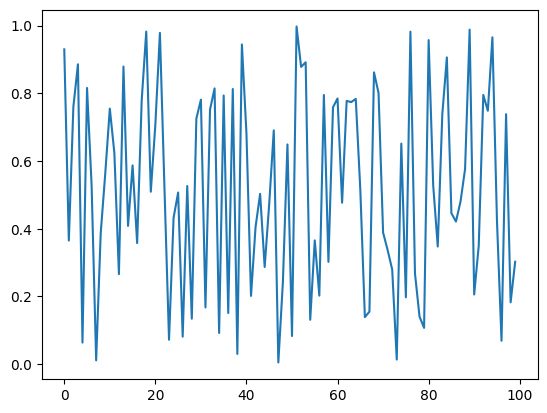

In [2]:

import matplotlib.pyplot as plt

plt.plot(np.arange(0, 100), np.random.rand(100))
plt.show()

As you can see the dataset contains quite a lot of information. In particular the ligand price in [$/gram] in the `Ligand_Cost_fixed` column.

In [3]:
reaction_data.data.keys()

Index(['Ligand_inchi', 'Base_inchi', 'Solvent_inchi', 'Product_inchi',
       'Electrophile_inchi', 'Nucleophile_inchi', 'Precatalyst_inchi', 'Base',
       'Electrophile', 'Electrophile_PCI_Name', 'Ligand', 'Nucleophile',
       'Nucleophile_PCI_Name', 'Precatalyst', 'Product', 'Solvent',
       'Screen_ID', 'umol_Screen', 'Entry', 'Well', 'Row', 'Column',
       'Base_Equiv', 'Electrophile_Equiv', 'Ligand_Equiv', 'Nucleophile_Equiv',
       'Precatalyst_Equiv', 'Concentration', 'Time_h', 'Temp_C', 'SampleName',
       'Vial', 'AP_ISO', 'AP_PDT', 'AP_STD', 'Mean_AP', 'Max_AP', 'SD_AP',
       'Z_Score_AP', 'RelYield_PDT', 'Mean_RY', 'Max_RY', 'SD_RY',
       'Z_Score_RY', 'Yield', 'Mean_Yield', 'Max_Yield', 'SD_Yield',
       'Z_Score_Yield', 'Product_MW', 'Solvent_density', 'Solvent_mass',
       'Product_mg', 'Base_Cost', 'Base_amt', 'Base_MW', 'Base_price.mol',
       'Solvent_Cost', 'Solvent_amt', 'Solvent_MW', 'Solvent_price.mol',
       'Ligand_Cost', 'Ligand_amt', 'Ligand_MW', 

Here is a histogram of the unique ligand costs in this dataset

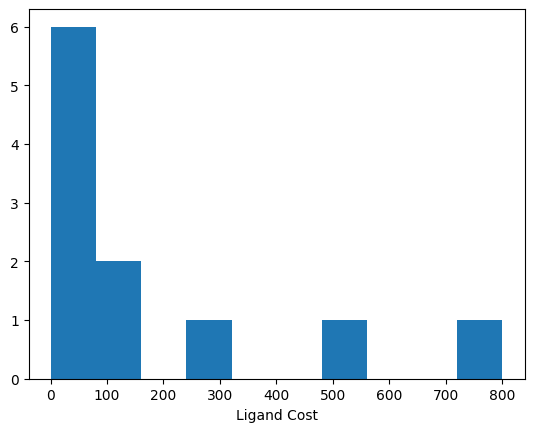

In [4]:
plt.hist(np.unique(reaction_data.data["Ligand_Cost_fixed"].values))
plt.xlabel("Ligand Cost")
plt.show()

Next we will featurize the data via ECFP fingerprints and reaction conditions such as temperature and concentration. Finally, the feature vectors will be normalized to have a range of 0 to 1 in each dimension. 

In [5]:
from data.datasets import Evaluation_data

DATASET = Evaluation_data(
    "BMS",
    200,
    "update_ligand_when_used",
    init_strategy="worst_ligand",
)

DATASET.get_init_holdout_data(111)

###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################


(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4479, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4479, 0.5000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4479, 1.0000]]),
 tensor([[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [19.0200],
         [ 5.9000],
         [ 0.0000],
         [ 3.5900],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 2.1

This is how you initialize the data:

In [6]:
(
    X_init,
    y_init,
    costs_init,
    X_candidate,
    y_candidate,
    costs_candidate,
    LIGANDS_init,
    LIGANDS_candidate,
    price_dict,
    exp_init,
    exp_candidate,
) = DATASET.get_init_holdout_data(111)

`X_init` are the representation vectors of the initial experiments and `y_init` are the corresponding yield measurements. 


`costs_init` contains an array of all the costs for the ligands for the initially collected data

`X_candidate` and `y_candidate` are representation vectors and measurements of the holdoutset respectively

`price_dict` is a dictionary of the current prices. Note that the inital ligand was already set to zero price as it was acquired before.

`exp_init` and `exp_candidate` are the experimental conditions corresponding to their vector `X_init` and `X_candidate` respectively.

Next we will just show a simple example how to perform a Cost-informed Bayesion optimization with CIBO

In [7]:
conf = {
    "dataset": "BMS",
    "init_strategy": "worst_ligand",
    "cost_aware": True,
    "n_runs": 5,
    "n_iter": 30,
    "batch_size": 5,
    "ntrain": 200,
    "prices": "update_ligand_when_used",
    "surrogate": "GP",
    "acq_func": "NEI",
    "label": "BMS_COST_GP_NEI",
    "cost_mod": "minus",
}

In [8]:
print("Starting experiment: ", conf)
y_better_BO_ALL, y_better_RANDOM_ALL = [], []
running_costs_BO_ALL, running_costs_RANDOM_ALL = [], []

DATASET = Evaluation_data(
    conf["dataset"],
    conf["ntrain"],
    conf["prices"],
    init_strategy=conf["init_strategy"],
)
bounds_norm = DATASET.bounds_norm
N_RUNS = conf["n_runs"]
NITER = conf["n_iter"]
BATCH_SIZE = conf["batch_size"]
SURROGATE = conf["surrogate"]
COST_AWARE_BO = conf["cost_aware"]

for run in range(N_RUNS):
    SEED = 111 + run
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    (
        X_init,
        y_init,
        costs_init,
        X_candidate,
        y_candidate,
        costs_candidate,
        LIGANDS_init,
        LIGANDS_candidate,
        price_dict,
        exp_init,
        exp_candidate,
    ) = DATASET.get_init_holdout_data(SEED)

    print(create_aligned_transposed_price_table(price_dict))
    X, y = cp.deepcopy(X_init), cp.deepcopy(y_init)
    y_best = float(torch.max(y))
    model, scaler_y = update_model(X, y, bounds_norm, surrogate=SURROGATE)
    X_candidate_FULL, y_candidate_FULL = cp.deepcopy(X_candidate), cp.deepcopy(
        y_candidate
    )
    X_candidate_BO = cp.deepcopy(X_candidate)
    y_candidate_BO = cp.deepcopy(y_candidate)
    exp_candidate_BO = cp.deepcopy(exp_candidate)


    y_candidate_RANDOM = cp.deepcopy(y_candidate).detach().numpy()
    exp_candidate_RANDOM = cp.deepcopy(exp_candidate)

    running_costs_BO = [0]
    running_costs_RANDOM = [0]

    price_dict_BO = cp.deepcopy(price_dict)
    price_dict_RANDOM = cp.deepcopy(price_dict)

    LIGANDS_candidate_BO = cp.deepcopy(LIGANDS_candidate)
    LIGANDS_candidate_RANDOM = cp.deepcopy(LIGANDS_candidate)

    y_better_BO = []
    y_better_RANDOM = []

    y_better_BO.append(y_best)
    y_better_RANDOM.append(y_best)
    y_best_BO, y_best_RANDOM = y_best, y_best

    BO_data = data_dict_BO_LIGAND(
        model,
        y_best_BO,
        scaler_y,
        X,
        y,
        X_candidate_BO,
        y_candidate_BO,
        LIGANDS_candidate_BO,
        y_better_BO,
        price_dict_BO,
        running_costs_BO,
        bounds_norm,
        BATCH_SIZE,
        None,
        SURROGATE,
        conf["acq_func"],
        exp_init,
        exp_candidate_BO,
    )

    BO_data["cost_mod"] = conf["cost_mod"]

    RANDOM_data = data_dict_RS_LIGAND(
        y_candidate_RANDOM,
        y_best_RANDOM,
        LIGANDS_candidate_RANDOM,
        price_dict_RANDOM,
        BATCH_SIZE,
        None,
        y_better_RANDOM,
        running_costs_RANDOM,
        exp_init,
        exp_candidate_RANDOM,
    )

    for i in range(NITER):
        if COST_AWARE_BO == False:
            BO_data = BO_LIGAND(BO_data)
        else:
            BO_data = BO_COI_LIGAND(BO_data)

        RANDOM_data = RS_LIGAND(RANDOM_data)

        print("--------------------")
        print(
            "# |{}/{}|\tBO {:.2f}\tRS {:.2f} \tSUM(COSTS BO): ${}\tSUM(COSTS RS): ${}\tN_train {}".format(
                i + 1,
                NITER,
                BO_data["y_best_BO"],
                RANDOM_data["y_best_RANDOM"],
                BO_data["running_costs_BO"][-1],
                RANDOM_data["running_costs_RANDOM"][-1],
                BO_data["N_train"],
            )
        )
        print(create_aligned_transposed_price_table(price_dict_BO))

    y_better_BO_ALL.append(BO_data["y_better_BO"])
    y_better_RANDOM_ALL.append(RANDOM_data["y_better_RANDOM"])
    running_costs_BO_ALL.append(BO_data["running_costs_BO"])
    running_costs_RANDOM_ALL.append(RANDOM_data["running_costs_RANDOM"])

y_better_BO_ALL = np.array(y_better_BO_ALL)
y_better_RANDOM_ALL = np.array(y_better_RANDOM_ALL)

Starting experiment:  {'dataset': 'BMS', 'init_strategy': 'worst_ligand', 'cost_aware': True, 'n_runs': 5, 'n_iter': 30, 'batch_size': 5, 'ntrain': 200, 'prices': 'update_ligand_when_used', 'surrogate': 'GP', 'acq_func': 'NEI', 'label': 'BMS_COST_GP_NEI', 'cost_mod': 'minus'}
###############################################
Entries of X are not between 0 and 1. Adding MinMaxScaler to the pipeline.
###############################################
Ligand 1  | Ligand 2  | Ligand 3  | Ligand 4  | Ligand 5  | Ligand 6  | Ligand 7  | Ligand 8  | Ligand 9  | Ligand 10 | Ligand 11 | Ligand 12
---------------------------------------------------------------------------------------------------------------------------------------------
22.0      | 102.0     | 36.0      | 24.0      | 144.0     | 800.0     | 297.0     | 552.0     | 0         | 8.0       | 1.0       | 72.0     
--------------------
# |1/30|	BO 89.71	RS 53.61 	SUM(COSTS BO): $9.0	SUM(COSTS RS): $427.0	N_train 149
Ligand 1  | Ligand 2  |

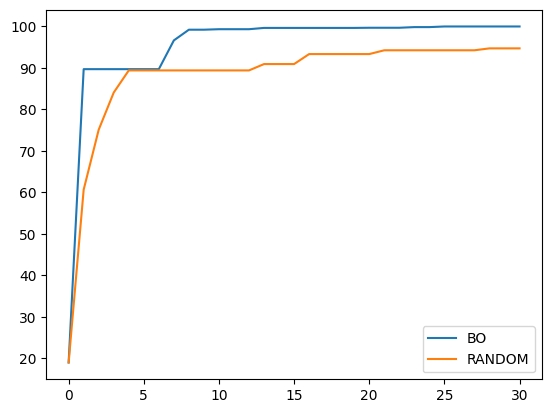

In [9]:
BO = np.mean(y_better_BO_ALL, axis=0)
RANDOM = np.mean(y_better_RANDOM_ALL, axis=0)


plt.figure()
plt.plot(BO, label="BO")
plt.plot(RANDOM, label="RANDOM")
plt.legend()
plt.show()